# ML : Tag classification

For this last part we wanted to do some Multilabel classification of the tags based on the text of each questions.
The constraint was to use :
1. `pyspark.ml` library
2. `pyspark.mllib` library
3. A third party library in a spark pipeline

We have been disapointed to learn that pyspark ml and mllib had multi label classification implementation for its algorithm.
Indeed those one can do multi class classification but not multi label. A way to go by this issue would have been to use a string indexer to transform our multlabel into problem one :
Example: if we have three classes $A,B,C$, the stringindexer creates new classes $AB,BC,AC,ABC$, so the model just becomes single label multiclass pb..
There are several problem this method : 
- Dimensionnality : we have a lot more than three tags in the sample. It would have been tramendous computations for really poor results
- A tramendous loose of in information, we would a have lost a part of the label correlation.

After some computation expensive non concluent tests we decided that we will do only multiclass classification on the 10 most used tags (which is often the most important as we alredy noticed). 

However, concerning the third part of the project, we decided to combine `tf.Keras` and `pyspark` (thanks to Elephas) to do this multilabel classification with a small neural network. 

In [3]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors as MLLibVectors

input_dim = 100
output_dim = 10

# TF
cv = sf.CountVectorizer(inputCol="text", outputCol="tf_features",vocabSize=100)
# IDF
idf = sf.IDF(inputCol="tf_features", outputCol="features")
label_string= sf.StringIndexer(inputCol="first_label", outputCol ="label")
pipeline_dl = Pipeline(stages=[cv, idf, label_string])
df = pipeline_dl.fit(training_set).transform(training_set)
df = df.rdd.map(lambda x :( LabeledPoint(x['label'],MLLibVectors.fromML(x['features']))))

In [4]:
df

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pyspark/serializers.py", line 437, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
  File "/usr/local/lib/python3.6/dist-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 101, in dumps
    cp.dump(obj)
  File "/usr/local/lib/python3.6/dist-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 540, in dump
    return Pickler.dump(self, obj)
  File "/usr/lib/python3.6/pickle.py", line 409, in dump
    self.save(obj)
  File "/usr/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/usr/lib/python3.6/pickle.py", line 751, in save_tuple
    save(element)
  File "/usr/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/usr/local/lib/python3.6/dist-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 722, in save_function
    *self._dynamic_function_reduce(obj), obj=obj
  Fi

PicklingError: Could not serialize object: ValueError: Cell is empty

In [4]:
import os
os.chdir(os.environ['HOME'])

In [ ]:

import argparse
import logging
from pyspark.ml.tuning import ParamGridBuilder

# Import Spark NLP
import pyspark
import pyspark.ml.feature as sf
from pyspark.ml import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from pyspark.mllib.regression import LabeledPoint
from elephas.spark_model import SparkMLlibModel
from pyspark.mllib.linalg import Vectors  as MLLibVectors


logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
c_handler = logging.StreamHandler()
f_handler = logging.FileHandler("myscript.log")
c_handler.setLevel(logging.DEBUG)
f_handler.setLevel(logging.DEBUG)
c_format = logging.Formatter('%(name)s - [%(levelname)s] - %(message)s')
f_format = logging.Formatter('%(asctime)s - %(name)s - [%(levelname)s] - %(message)s')
c_handler.setFormatter(c_format)
f_handler.setFormatter(f_format)
logger.addHandler(c_handler)
logger.addHandler(f_handler)

def create_keras_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(256, input_shape=(input_dim,)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model


seed = 2020
input_dim = 100
output_dim = 10
save_dir = "models"
model_dir = "/nn"
features = "text"
label = "first_label"
data_dir = "/home/loic/train/training_sample"

logger.info("Starting Spark Context")

conf = (pyspark
        .SparkConf()
        .set("spark.ui.showConsoleProgress", "true")
       )
sc = pyspark.SparkContext.getOrCreate(conf=conf)
sqlcontext = pyspark.SQLContext(sc)
training_set = (sqlcontext
                 .read
                 .format("parquet")
                 .option("header",True)
                 .load(data_dir)
                )


# TF
cv = sf.CountVectorizer(inputCol="text", outputCol="tf_features",vocabSize=100)
# IDF
idf = sf.IDF(inputCol="tf_features", outputCol="features")
label_string= sf.StringIndexer(inputCol="first_label", outputCol ="label")
pipeline_dl = Pipeline(stages=[cv, idf, label_string])
df = pipeline_dl.fit(training_set).transform(training_set)
df = df.rdd.map(lambda x :( LabeledPoint(x['label'],MLLibVectors.fromML(x['features']))))
logger.info("Pipeline created ...")
logger.info("Transforms the text into tf idf RDD ...")
model = create_keras_model(input_dim, output_dim)

logger.info("Starts Training ...")
spark_model = SparkMLlibModel(model=model, frequency='epoch', mode='asynchronous',parameter_server_mode='socket')
spark_model.fit(df, epochs=20, batch_size=132, verbose=1, validation_split=0.1, categorical=True, nb_classes=output_dim)

logger.info("Training done")
spark_model._master_network.save(save_dir + model_dir + "/" + filename)
logger.info("Program ended succesfully ! Find the model at :" + save_dir + model_dir + "/" + filename)

__main__ - [INFO] - Starting Spark Context
__main__ - [INFO] - Pipeline created ...
__main__ - [INFO] - Transforms the text into tf idf RDD ...
__main__ - [INFO] - Starts Training ...


>>> Initialize workers
>>> Distribute load


In [38]:
c = df.limit(2).rdd.collect()

In [41]:
x = c[0]

In [48]:
LabeledPoint(x['label'],MLLibVectors.fromML(x['features']))

LabeledPoint(2.0, (100,[0,1,2,29,66,96],[0.1485895100317271,0.24479166668773555,1.1634010414442222,6.222954263108608,2.334454863314908,2.685990587855386]))

In [57]:
from pyspark.mllib.linalg import Vectors as MLLibVectors

a.rdd.collect()

[Row(text=['2nd', 'pair', 'deletion', 'list', 'pre', 'class', 'lang', 'py', 'prettyprint', 'override', 'code', 'letter', 'pair', 'list', 'adjacent', 'iterate', 'list', 'end', 'letter', 'pair'], first_label='python', tf_features=SparseVector(5000, {0: 1.0, 1: 1.0, 2: 1.0, 29: 3.0, 66: 1.0, 96: 1.0, 166: 1.0, 222: 1.0, 246: 1.0, 748: 2.0, 1003: 3.0, 1065: 1.0, 1556: 1.0}), features=SparseVector(5000, {0: 0.1486, 1: 0.2448, 2: 1.1634, 29: 6.223, 66: 2.3345, 96: 2.686, 166: 2.7717, 222: 3.6262, 246: 3.1515, 748: 9.3471, 1003: 15.1118, 1065: 4.6312, 1556: 5.165}), label=2.0),
 Row(text=['3d', 'skeleton', 'series', 'dicom', 'vessel', 'segmentation', 'work', 'dicom', 'series', 'process', 'test', 'develop', 'segmentation', 'slice', 'order', 'compute', 'skeleton', 'medial', 'axis', 'transform', 'center', 'line', '2dimensional', 'segment', 'region', 'convert', '2d', 'skeleton', 'slice', 'single', '3d', 'skeleton', 'lie', 'center', 'line', 'voxel', 'area', 'belong', 'segment', 'region', 'algorith

In [35]:
LabeledPoint

pyspark.mllib.regression.LabeledPoint

In [25]:
df = pipeline_dl.fit(training_set).transform(training_set)

In [30]:
df.limit(1).rdd.map(lambda x :( LabeledPoint(x.label,MLLibVectors.fromML(x.features))))

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pyspark/serializers.py", line 437, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
  File "/usr/local/lib/python3.6/dist-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 101, in dumps
    cp.dump(obj)
  File "/usr/local/lib/python3.6/dist-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 540, in dump
    return Pickler.dump(self, obj)
  File "/usr/lib/python3.6/pickle.py", line 409, in dump
    self.save(obj)
  File "/usr/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/usr/lib/python3.6/pickle.py", line 751, in save_tuple
    save(element)
  File "/usr/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/usr/local/lib/python3.6/dist-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 722, in save_function
    *self._dynamic_function_reduce(obj), obj=obj
  Fi

PicklingError: Could not serialize object: ValueError: Cell is empty

In [28]:
df.show()

+--------------------+-----------+--------------------+--------------------+-----+
|                text|first_label|         tf_features|            features|label|
+--------------------+-----------+--------------------+--------------------+-----+
|[2nd, pair, delet...|     python|(5000,[0,1,2,29,6...|(5000,[0,1,2,29,6...|  2.0|
|[3d, skeleton, se...|     python|(5000,[15,47,65,1...|(5000,[15,47,65,1...|  2.0|
|[__str__, return,...|     python|(5000,[0,1,2,5,6,...|(5000,[0,1,2,5,6,...|  2.0|
|[access, autocomp...|         c#|(5000,[21,28,39,5...|(5000,[21,28,39,5...|  3.0|
|[access, complex,...|         c#|(5000,[0,1,2,3,6,...|(5000,[0,1,2,3,6,...|  3.0|
|[access, data, aj...| javascript|(5000,[0,1,7,21,5...|(5000,[0,1,7,21,5...|  0.0|
|[access, header, ...| javascript|(5000,[0,1,2,3,7,...|(5000,[0,1,2,3,7,...|  0.0|
|[access, iframe, ...|     python|(5000,[0,1,3,5,15...|(5000,[0,1,3,5,15...|  2.0|
|[access, key, iam...|       java|(5000,[12,22,100,...|(5000,[12,22,100,...|  1.0|
|[ac

In [1]:


import stack_overflow_functions.DataLoader as data_loader
import stack_overflow_functions.DataTransformation as data_transfo
from pycountry_convert import country_name_to_country_alpha3
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
import patoolib
import gdown
# Import Spark NLP
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql.types import StructField, StructType, StringType, ArrayType,IntegerType, FloatType

import pyspark
import sparknlp
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from geopy.geocoders import Nominatim
import pyspark.sql.functions as F
from pyspark.sql.types import LongType, StringType
import pandas as pd
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import geopandas as gpd 
import matplotlib.pyplot as plt
import seaborn as sns
import json


from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
import pyspark.ml.feature as sf
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator

seed = 2020

In [2]:
spark = sparknlp.start()
conf = (pyspark
        .SparkConf()
        .set("spark.ui.showConsoleProgress", "true")
       )
sc = pyspark.SparkContext.getOrCreate(conf=conf)
sqlcontext = pyspark.SQLContext(sc)

In [3]:
data_loader.download_data()

All the data folder already exists, we infer that you have already downloaded or extracted the data. If it is not the case delete the data folder (Data/sample) and re run this function.


'Done, data can be found at /home/loic/Data/sample.'

### First part : clean the data
We use a similar Pipeline that for our feature/target analysis in order to perform ML on it. It was a choice of us to not put it into a module and call it to be clearer on the steps we have done. 
It is also a choice that we do not include those steps in the ML since they are computionnaly costly and unlikely to changed. 

#### Reads the data

In [4]:
%%time
post_dir = "Data/sample/Posts"
posts = (sqlcontext
         .read
         .format("parquet")
         .option("header",True)
         .load(post_dir)
         .sample(False, 0.01)
         .select("Id",
                  F.concat_ws(' ',F.col('Title'),F.col('Body')).alias("full_text"),
                  "Tags"
                )
        )

CPU times: user 23.8 ms, sys: 0 ns, total: 23.8 ms
Wall time: 1min 11s


#### Splits tags

In [5]:
tags_split =tags_split = F.regexp_replace( F.regexp_replace(
    F.regexp_replace(F.col('Tags'), '&lt;', ''), "&gt;", "<split_token>"), " ", "")

udf_drop = F.udf(lambda x: re.sub("'","",str(x[:-1])[1:-1]) if isinstance(x,list) else None,StringType())

posts = (
    posts
    .withColumn('Splitted_tags', tags_split)
    .withColumn('Splitted_tags', F.split(F.col("Splitted_tags"), "<split_token>"))
    .withColumn('Splitted_tags', udf_drop(F.col("Splitted_tags")))
    .withColumn('Splitted_tags', F.split(F.col("Splitted_tags"),","))
    .drop('Tags')
)



#### Clean text

In [6]:
input_col = "full_text"
clean_up_patterns = [
                    "p&gt;"
                    ,"&.*?;\space"
                    ,'&.*?;'                
                    ,"/.*?;"
                    ,"/code"
                    ,"/pre"
                    ,'/p'
                    ,"/a"
                    ,"href="
                    ,"lt;"
                    ,"gt;"
                    ,"[^\w\s]"
                    ,r"\b\d+\b"
                  ]


# Document assembler : Tokenize our text
documentAssembler = DocumentAssembler() \
    .setInputCol(input_col) \
    .setOutputCol('_intermediate_results')

# Document normalizer : Normalize the document
# by lowercasing, removing non utf8 chars
# and remove regex oattern defined
doc_norm = DocumentNormalizer() \
    .setInputCols("_intermediate_results") \
    .setOutputCol(input_col + "_cleaned") \
    .setAction("clean") \
    .setPatterns(clean_up_patterns) \
    .setReplacement(" ") \
    .setPolicy("pretty_all") \
    .setLowercase(True)

# Document tokenizer : allows to remove
# undesired tokens (punctuations etc.)
# prepare the colums for the stopwords 
# remover
tokenizer = Tokenizer() \
    .setInputCols([input_col + "_cleaned"]) \
    .setOutputCol("token") \
    .setSplitChars(['-']) \
    .setContextChars(['(', ')', '?', '!']) \
    .setSplitPattern("'") \
    .setMaxLength(0) \
    .setMaxLength(99999) \
    .setCaseSensitiveExceptions(False)


# StopWordsCleaner : remove 
# the stopwords based on
# a predifined list
Stop_words_cleaner = (
    StopWordsCleaner()
    .pretrained("stopwords_en", "en")
    .setInputCols(["token"])
    .setOutputCol(input_col + "_without_stopwords") 
    .setCaseSensitive(False) 
    .setLazyAnnotator(False)
)

# Lemmatize the text 
# thanks to the lemmatizing tab
# defined above
Lemmatizer_cleaner = (
    Lemmatizer() 
    .setInputCols([input_col + "_without_stopwords"]) 
    .setOutputCol(input_col + "_lemmatized") 
    .setDictionary("./Data/lemmatizer/AntBNC_lemmas_ver_001.txt", value_delimiter ="\t", key_delimiter = "->") 
    .setLazyAnnotator(False)
)


# Creates thepipeline
cleaning_pipeline = (
    Pipeline() 
    .setStages([
        documentAssembler,
        doc_norm,
        tokenizer,
        #Document_cleaner,
        Stop_words_cleaner,
        Lemmatizer_cleaner])
)


posts_ml = (
    cleaning_pipeline
    .fit(posts)
    .transform(posts)
    .select(F.col("Id"),
            F.col(input_col),
            F.col(input_col + "_lemmatized.result"),
            F.col("Splitted_tags")
           )
) 


stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]


### Second Part : `pyspark.ml` pipeline 

In [15]:
top = 10
tags = (posts_ml
        .select(F.explode('Splitted_tags').alias("tags"))
        .select(F.trim("tags").alias("tags"))
        .groupBy('tags')
        .count()
       ).toPandas()

In [16]:
top = 10
top10 = tags.sort_values(by ="count",ascending = False).head(top).tags.tolist()

In [17]:
posts_ml = (
    posts_ml
    .withColumn('language_deduced',
                data_transfo.udf_detect_language(top10)(F.col('Splitted_tags'))))

In [18]:
posts_multi_class = (posts_ml
                     .select(F.col('result').alias("text"),
                            data_transfo.udf_detect_language(top10)(F.col('Splitted_tags')).alias("first_label"))
                     .where(F.col('first_label').isNotNull())
                    )
posts_multi_class.cache().count()

11029

In [19]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
train_split, test_split = posts_multi_class.randomSplit(weights=[0.80, 0.20], seed=seed)

In [20]:
posts_multi_class.show()

+--------------------+-----------+
|                text|first_label|
+--------------------+-----------+
|[socks5, proxy, c...|         c#|
|[pass, id, input,...| javascript|
|[machine, learn, ...|     python|
|[pass, parameter,...| javascript|
|[access, global, ...| javascript|
|[determine, minim...|     python|
|[run, modal, base...|        php|
|[filter, convert,...|        php|
|[java, empty, loo...|       java|
|[mac, run, python...|     python|
|[instantiate, reg...|        c++|
|[return, data, st...|       java|
|[css, rotate, aut...|        css|
|[display, file, s...|        php|
|[android, string,...|       java|
|[discord, bot, le...|     python|
|[capture, chrome,...|       java|
|[concept, concept...|        c++|
|[add, border, blu...|        css|
|[eliminate, block...| javascript|
+--------------------+-----------+
only showing top 20 rows



In [22]:
features = "text"
label = "first_label"

# TF
cv = sf.CountVectorizer(inputCol=features, outputCol="tf_features")

# IDF
idf = sf.IDF(inputCol="tf_features", outputCol="features")

# StringIndexer 
label_string= sf.StringIndexer(inputCol=label, outputCol ="label")

# Logistic regression
lr = LogisticRegression(maxIter=10,family="multinomial")
pipeline = Pipeline(stages=[cv, idf, label_string, lr])

paramGrid = (ParamGridBuilder() 
             .addGrid(cv.vocabSize, [10, 100, 1000, 5000]) 
             .addGrid(lr.regParam, [0.1, 0.01, 0.001]) 
             .build()
            )

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=4)  

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_split)

In [23]:
import pandas as pd

def get_cv_results(crossval_model):
    params = [{p.name: v for p, v in m.items()} for m in crossval_model.getEstimatorParamMaps()]

    results = pd.DataFrame.from_dict([
        {crossval_model.getEvaluator().getMetricName(): metric, **ps} 
        for ps, metric in zip(params, crossval_model.avgMetrics)
    ])
    return results
get_cv_results(cvModel)

,f1,vocabSize,regParam
0,0.192263,10,0.100
1,0.270825,10,0.010
2,0.330494,10,0.001
3,0.484280,100,0.100
4,0.564011,100,0.010
5,0.574920,100,0.001
6,0.652115,1000,0.100
7,0.678319,1000,0.010
8,0.685599,1000,0.001
9,0.665056,5000,0.100


In [24]:
from pyspark.mllib.evaluation import MulticlassMetrics
preds_test = cvModel.transform(test_split)

# Compute raw scores on the test set
predictionAndLabels = preds_test.rdd.map(lambda lp: (float(lp.prediction), lp.label))
labels = preds_test.rdd.map(lambda lp: lp.label).distinct().collect()

def evaluation_metrics(predictionAndLabels, labels):
    """
    Computes the multiclass metrics for predictions and labels 
    args:
        predictionAndLabels: And RDD composed of (prediction, label)
        labels: A list of the unique labels to predict
    returns:
        metrics_results(df) : The multi class metrics by labels
        global_metrics(dict) : The global metrics 
        confusion_matrix (df): The confusion Matrix
    """

    metrics = MulticlassMetrics(predictionAndLabels)

    results = []
    # Statistics by class
    
    for label in sorted(labels):
        results.append((label, metrics.precision(label),metrics.recall(label), metrics.fMeasure(label, beta=1.0)))
    metrics_results = pd.DataFrame(results, columns = ['Label', "Precision","Recall","F1"])

    # Weighted stats
    global_metrics = {}
    global_metrics["weightedRecall"] = metrics.weightedRecall
    global_metrics["weightedPrecision"] = metrics.weightedPrecision
    global_metrics["weightedFMeasure"] = metrics.weightedFMeasure()
    global_metrics["weightedFPR"] = metrics.weightedFalsePositiveRate
    
    # Confusion Matrix
    confusion_matrix = pd.DataFrame(metrics.confusionMatrix().toArray(), columns = labels, index=labels)
    return metrics_results, global_metrics, confusion_matrix

metrics_results, global_metrics, confusion_matrix = evaluation_metrics(predictionAndLabels, labels)

# Put it into list:
label_string.fit(test_split).transform(test_split).select(label, "label").distinct().toPandas().to_dict()

{'first_label': {0: 'php',
  1: 'javascript',
  2: 'css',
  3: 'python',
  4: 'jquery',
  5: 'java',
  6: 'html',
  7: 'c++',
  8: 'c#',
  9: 'android'},
 'label': {0: 4.0,
  1: 0.0,
  2: 9.0,
  3: 2.0,
  4: 8.0,
  5: 1.0,
  6: 7.0,
  7: 6.0,
  8: 3.0,
  9: 5.0}}

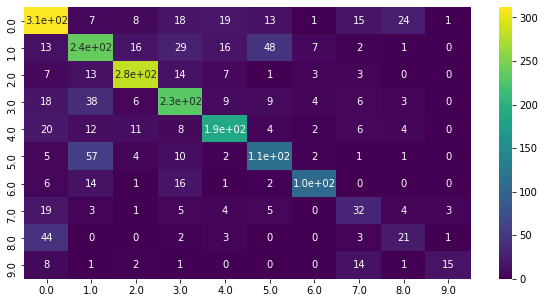

In [25]:
# add confusion matrix from pd.crosstab earlier
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix,annot=True,cmap="viridis");

In [28]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from pyspark.mllib.feature import HashingTF, IDF

all_tags = (
            posts_ml
                .select(F.explode("Splitted_tags").alias('t'))
                .select(F.trim("t").alias('t'))
                .groupby("t")
                .count()
                .filter(F.col('count') >= 100)
                .collect()
)
i=0
match_tags = {}
for tag in all_tags:
    m_tag = tag['t'].strip()
    match_tags[m_tag] = i
    i += 1
    

def map_tags(tag_list):
    label = np.zeros(len(match_tags.keys()),dtype=int)
    mask = []
    for tag in tag_list:
        tag_m = tag.strip()
        for key, value in match_tags.items():
            if tag_m == key:
                mask.append(value)
                pass
    label[mask] = 1
    return label.tolist()

udf_map = F.udf(map_tags, StringType())
posts_ml = posts_ml.withColumn("label_to_encode", udf_map('Splitted_tags'))

In [29]:
post_multi_label

DataFrame[Id: string, full_text: string, result: array<string>, Splitted_tags: array<string>, language_deduced: string, label_to_encode: string]

In [50]:
udf_map = F.udf(map_tags, ArrayType(FloatType()))
post_multi_label = (posts_ml
                    .withColumn("label_to_encode", udf_map('Splitted_tags'))
                    .withColumn("string_result", F.concat_ws(" ", 'result'))
                   )
post_multi_label.show()

+--------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+
|      Id|           full_text|              result|       Splitted_tags|language_deduced|     label_to_encode|       string_result|
+--------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+
|63216635|amCharts 4: Is it...|[amcharts, sort, ...|[amcharts,  amcha...|            null|[null, null, null...|amcharts sort cat...|
|63216729|Why does the orde...|[order, implicit,...|[scala,  generics...|            null|[null, null, null...|order implicit pa...|
|63218923|How do Flink job ...|[flink, job, mana...|[apache-flink,  f...|            null|[null, null, null...|flink job manager...|
|63220073|C# Using a random...|[random, number, ...|[c#,  arrays,  en...|              c#|[null, null, null...|random number gen...|
|63222764|AVCaptureMovieFil...|[avcapturemoviefi...|[swift,  freeze, 

In [51]:
post_multi_label

DataFrame[Id: string, full_text: string, result: array<string>, Splitted_tags: array<string>, language_deduced: string, label_to_encode: array<float>, string_result: string]

In [26]:
!pip3 install elephas

Defaulting to user installation because normal site-packages is not writeable
     |################################| 2.0 MB 2.8 MB/s eta 0:00:01
     |################################| 336 kB 20.7 MB/s eta 0:00:01
     |################################| 965 kB 18.7 MB/s eta 0:00:01
     |################################| 1.6 MB 8.4 MB/s eta 0:00:01
     |################################| 829 kB 25.5 MB/s eta 0:00:01


     |################################| 119 kB 36.4 MB/s eta 0:00:01
     |################################| 121 kB 24.0 MB/s eta 0:00:01
     |################################| 243 kB 18.9 MB/s eta 0:00:01
     |################################| 2.2 MB 20.6 MB/s eta 0:00:01
     |################################| 54 kB 325 kB/s  eta 0:00:01
  Created wheel for elephas: filename=elephas-2.0.0-py3-none-any.whl size=28112 sha256=5c9e2f2247f69f1c9341e1a4926e898d200b7694d374e742100a76047906d3c7
  Stored in directory: /home/loic/.cache/pip/wheels/bc/01/45/6236af14a66f3d7337b8d75d1a56de8a93d0b88e0985b6d1e1
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=493275 sha256=7fb6b7ac5f1cd633629c0f4f6c5f73699a32c968ffaad21a3d036b996a41931e
  Stored in directory: /home/loic/.cache/pip/wheels/6e/9c/ed/4499c9865ac1002697793e0ae05ba6be33553d098f3347fb94
Successfully built elephas future
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-

In [85]:
train_split

DataFrame[text: array<string>, first_label: string]

In [39]:
from elephas.spark_model import SparkModel
from pyspark.mllib.feature import HashingTF, IDF

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from pyspark.mllib.feature import HashingTF, IDF

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from pyspark.mllib.feature import HashingTF, IDF

input_dim = 100
output_dim = len(match_tags.keys())

# TF
cv = sf.CountVectorizer(inputCol="result", outputCol="tf_features",vocabSize=100)
# IDF
idf = sf.IDF(inputCol="tf_features", outputCol="features")
pipeline_dl = Pipeline(stages=[cv, idf])
post_multi_label_rdd = pipeline_dl.fit(post_multi_label).transform(post_multi_label).rdd.map(lambda row: LabeledPoint(row['label_to_encode'], row['features']))

model = Sequential()
model.add(Dense(128, input_dim=input_dim))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(output_dim))
model.add(Activation('sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=Adam())

KeyboardInterrupt: 

In [83]:
df.rdd.map(lambda row: LabeledPoint(row['deduced_'], row['features'])).collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 102.0 failed 1 times, most recent failure: Lost task 1.0 in stage 102.0 (TID 5948) (986495218aca executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-83-25bfd24ef7de>", line 1, in <lambda>
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/mllib/regression.py", line 58, in __init__
    self.label = float(label)
TypeError: float() argument must be a string or a number, not 'list'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2242)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2267)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-83-25bfd24ef7de>", line 1, in <lambda>
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/mllib/regression.py", line 58, in __init__
    self.label = float(label)
TypeError: float() argument must be a string or a number, not 'list'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2242)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [79]:

model = Sequential()
model.add(Dense(512, input_shape=(input_dim,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(output_dim))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               1024      
_________________________________________________________________
activation_24 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_25 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)              

In [73]:
from elephas.ml_model import ElephasEstimator
from tensorflow.keras import optimizers
adam = optimizers.Adam(lr=0.01)
opt_conf = optimizers.serialize(adam)
# Initialize SparkML Estimator and set all relevant properties
estimator = ElephasEstimator()
estimator.setFeaturesCol("features")             # These two come directly from pyspark,
estimator.setLabelCol("label_to_encode")                 # hence the camel case. Sorry :)
estimator.set_keras_model_config(model.to_yaml())       # Provide serialized Keras model
estimator.set_categorical_labels(True)
estimator.set_nb_classes(output_dim)
estimator.set_num_workers(1)  # We just use one worker here. Feel free to adapt it.
estimator.set_epochs(1) 
estimator.set_batch_size(128)
estimator.set_verbosity(1)
estimator.set_validation_split(0.15)
estimator.set_optimizer_config(opt_conf)
estimator.set_mode("synchronous")
estimator.set_loss("categorical_crossentropy")
estimator.set_metrics(['acc'])
pipeline = Pipeline(stages=[ estimator])

In [74]:
from pyspark.mllib.evaluation import MulticlassMetrics

fitted_pipeline = pipeline.fit(df) # Fit model to data

prediction = fitted_pipeline.transform(df) # Evaluate on train data.

AttributeError: 'Sequential' object has no attribute 'compiled_metrics'

In [67]:
model.to_yaml()

'backend: tensorflow\nclass_name: Sequential\nconfig:\n  layers:\n  - class_name: Dense\n    config:\n      activation: linear\n      activity_regularizer: null\n      batch_input_shape: !!python/tuple\n      - null\n      - 100\n      bias_constraint: null\n      bias_initializer:\n        class_name: Zeros\n        config: {}\n      bias_regularizer: null\n      dtype: float32\n      kernel_constraint: null\n      kernel_initializer:\n        class_name: GlorotUniform\n        config:\n          seed: null\n      kernel_regularizer: null\n      name: dense_12\n      trainable: true\n      units: 512\n      use_bias: true\n  - class_name: Activation\n    config:\n      activation: relu\n      dtype: float32\n      name: activation_12\n      trainable: true\n  - class_name: Dropout\n    config:\n      dtype: float32\n      name: dropout_8\n      noise_shape: null\n      rate: 0.5\n      seed: null\n      trainable: true\n  - class_name: Dense\n    config:\n      activation: linear\n   